In [1]:
pip install torchsummary

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import time
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from datetime import datetime

In [3]:

transform = transforms.Compose(
        [transforms.Resize((224, 224)),
         transforms.Grayscale(num_output_channels=3),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [4]:
pip install gdown

Note: you may need to restart the kernel to use updated packages.


In [5]:
import gdown
split_ratio = 0.8 #<--- range of spliting dataset ratio {'training_size':0.8, 'testing_size':0.2}
ds = torchvision.datasets.Caltech101(root='./data',
                                     transform=transform,
                                     download=True)
train_size = int(split_ratio * len(ds))
test_size = len(ds) - train_size
training_set, validation_set = torch.utils.data.random_split(ds, [train_size, test_size])
training_loader = torch.utils.data.DataLoader(training_set, batch_size=16, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=16, shuffle=False)

Downloading...
From (original): https://drive.google.com/uc?id=137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp
From (redirected): https://drive.usercontent.google.com/download?id=137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp&confirm=t&uuid=3ddca90b-e32b-4534-944b-a844d9b6736e
To: /kaggle/working/data/caltech101/101_ObjectCategories.tar.gz
100%|██████████| 132M/132M [00:00<00:00, 262MB/s]


Extracting ./data/caltech101/101_ObjectCategories.tar.gz to ./data/caltech101


Downloading...
From (original): https://drive.google.com/uc?id=175kQy3UsZ0wUEHZjqkUDdNVssr7bgh_m
From (redirected): https://drive.usercontent.google.com/download?id=175kQy3UsZ0wUEHZjqkUDdNVssr7bgh_m&confirm=t&uuid=d2d1ca0b-69e0-4f33-9009-23b357ab383e
To: /kaggle/working/data/caltech101/Annotations.tar
100%|██████████| 14.0M/14.0M [00:00<00:00, 234MB/s]


Extracting ./data/caltech101/Annotations.tar to ./data/caltech101


In [6]:
import matplotlib.pyplot as plt
import numpy as np

def plot_graph(history):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_figwidth(10)
    fig.suptitle("Train vs Validation")
    ax1.plot(history["train_acc"], label="Train")
    ax1.plot(history["validate_acc"], label="Validation")
    ax1.legend()
    ax1.set_title("Accuracy")

    ax2.plot(history["train_loss"], label="Train")
    ax2.plot(history["validate_loss"], label="Validation")
    ax2.legend()
    ax2.set_title("Loss")
    fig.show()

In [7]:
model_urls = {
     'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
     'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
     'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
     'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
     'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
 }

In [8]:
import torch.nn as nn
import math

'''
MobileNetV3 From <Searching for MobileNetV3>, arXiv:1905.02244.
Arg:
    Creates a MobileNetV3 Model as defined in:
    Andrew Howard, Mark Sandler, Grace Chu, Liang-Chieh Chen, Bo Chen, Mingxing Tan, Weijun Wang, Yukun Zhu, Ruoming Pang, Vijay Vasudevan, Quoc V. Le, Hartwig Adam. (2019).
    Searching for MobileNetV3
    arXiv preprint arXiv:1905.02244.
Ref:
    https://github.com/d-li14/mobilenetv3.pytorch/blob/master/mobilenetv3.py
    https://github.com/kuan-wang/pytorch-mobilenet-v3/blob/master/mobilenetv3.py

'''
__all__ = ['mobilenetv3_large', 'mobilenetv3_small']


def _make_divisible(v, divisor, min_value=None):
    """
    This function is taken from the original tf repo.
    It ensures that all layers have a channel number that is divisible by 8
    It can be seen here:
    https://github.com/tensorflow/models/blob/master/research/slim/nets/mobilenet/mobilenet.py
    :param v:
    :param divisor:
    :param min_value:
    :return:
    """
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor)
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v


class h_sigmoid(nn.Module):
    def __init__(self, inplace=True):
        super(h_sigmoid, self).__init__()
        self.relu = nn.ReLU6(inplace=inplace)

    def forward(self, x):
        return self.relu(x + 3) / 6


class h_swish(nn.Module):
    def __init__(self, inplace=True):
        super(h_swish, self).__init__()
        self.sigmoid = h_sigmoid(inplace=inplace)

    def forward(self, x):
        return x * self.sigmoid(x)


class SELayer(nn.Module):
    def __init__(self, channel, reduction=4):
        super(SELayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
                nn.Linear(channel, _make_divisible(channel // reduction, 8)),
                nn.ReLU(inplace=True),
                nn.Linear(_make_divisible(channel // reduction, 8), channel),
                h_sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y


def conv_3x3_bn(inp, oup, stride):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        h_swish()
    )


def conv_1x1_bn(inp, oup):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
        h_swish()
    )


class InvertedResidual(nn.Module):
    def __init__(self, inp, hidden_dim, oup, kernel_size, stride, use_se, use_hs):
        super(InvertedResidual, self).__init__()
        assert stride in [1, 2]

        self.identity = stride == 1 and inp == oup

        if inp == hidden_dim:
            self.conv = nn.Sequential(
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, kernel_size, stride, (kernel_size - 1) // 2, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                h_swish() if use_hs else nn.ReLU(inplace=True),
                # Squeeze-and-Excite
                SELayer(hidden_dim) if use_se else nn.Identity(),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )
        else:
            self.conv = nn.Sequential(
                # pw
                nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                h_swish() if use_hs else nn.ReLU(inplace=True),
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, kernel_size, stride, (kernel_size - 1) // 2, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                # Squeeze-and-Excite
                SELayer(hidden_dim) if use_se else nn.Identity(),
                h_swish() if use_hs else nn.ReLU(inplace=True),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup),
            )

    def forward(self, x):
        if self.identity:
            return x + self.conv(x)
        else:
            return self.conv(x)


class mobilenetv3_large(nn.Module):
    def __init__(self,
                 n_C=1000,
                 width_mult=1.,
                 ):
        super(mobilenetv3_large, self).__init__()
        # setting of inverted residual blocks
        self.cfgs = [
        # k, t, c, SE, HS, s
        [3,   1,  16, 0, 0, 1],
        [3,   4,  24, 0, 0, 2],
        [3,   3,  24, 0, 0, 1],
        [5,   3,  40, 1, 0, 2],
        [5,   3,  40, 1, 0, 1],
        [5,   3,  40, 1, 0, 1],
        [3,   6,  80, 0, 1, 2],
        [3, 2.5,  80, 0, 1, 1],
        [3, 2.3,  80, 0, 1, 1],
        [3, 2.3,  80, 0, 1, 1],
        [3,   6, 112, 1, 1, 1],
        [3,   6, 112, 1, 1, 1],
        [5,   6, 160, 1, 1, 2],
        [5,   6, 160, 1, 1, 1],
        [5,   6, 160, 1, 1, 1]
        ]

        # building first layer
        input_channel = _make_divisible(16 * width_mult, 8)
        layers = [conv_3x3_bn(3, input_channel, 2)]
        # building inverted residual blocks
        block = InvertedResidual
        for k, t, c, use_se, use_hs, s in self.cfgs:
            output_channel = _make_divisible(c * width_mult, 8)
            exp_size = _make_divisible(input_channel * t, 8)
            layers.append(block(input_channel, exp_size, output_channel, k, s, use_se, use_hs))
            #print("layers:",len(layers))    #16
            input_channel = output_channel
        self.features = nn.Sequential(*layers)

        # building last several layers
        self.conv = conv_1x1_bn(input_channel, exp_size)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        output_channel = 1280
        output_channel = _make_divisible(output_channel * width_mult, 8) if width_mult > 1.0 else output_channel
        self.classifier = nn.Sequential(
            nn.Linear(exp_size, output_channel),
            h_swish(),
            nn.Dropout(0.2),
            nn.Linear(output_channel, n_C),
        )
        self._initialize_weights()

    def forward(self, x):
        # x = self.features(x)
        # encoder
        x = self.features[0](x) #conv2d
        x = self.features[1](x) #bneck 3x3
        x = self.features[2](x) #bneck 3x3
        x = self.features[3](x) #bneck 3x3
        x = self.features[4](x) #bneck 5x5
        x = self.features[5](x) #bneck 5x5
        x = self.features[6](x) #bneck 5x5
        x = self.features[7](x) #bneck 3x3
        x = self.features[8](x) #bneck 3x3
        x = self.features[9](x) #bneck 3x3
        x = self.features[10](x) #bneck 3x3
        x = self.features[11](x) #bneck 3x3
        x = self.features[12](x) #bneck 3x3
        x = self.features[13](x) #bneck 5x5
        x = self.features[14](x) #bneck 5x5
        x = self.features[15](x) #bneck 5x5
        x = self.conv(x)

        x = self.avgpool(x)
        fc = x.view(x.size(0), -1)
        out = self.classifier(fc)

        return out

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()



class mobilenetv3_small(nn.Module):
    def __init__(self,
                 n_C=1000,
                 width_mult=1.,
                 ):
        super(mobilenetv3_small, self).__init__()
        # setting of inverted residual blocks
        self.cfgs = [
        # k, t, c, SE, HS, s
        [3,    1,  16, 1, 0, 2],
        [3,  4.5,  24, 0, 0, 2],
        [3, 3.67,  24, 0, 0, 1],
        [5,    4,  40, 1, 1, 2],
        [5,    6,  40, 1, 1, 1],
        [5,    6,  40, 1, 1, 1],
        [5,    3,  48, 1, 1, 1],
        [5,    3,  48, 1, 1, 1],
        [5,    6,  96, 1, 1, 2],
        [5,    6,  96, 1, 1, 1],
        [5,    6,  96, 1, 1, 1],
        ]

        # building first layer
        input_channel = _make_divisible(16 * width_mult, 8)
        layers = [conv_3x3_bn(3, input_channel, 2)]
        # building inverted residual blocks
        block = InvertedResidual
        for k, t, c, use_se, use_hs, s in self.cfgs:
            output_channel = _make_divisible(c * width_mult, 8)
            exp_size = _make_divisible(input_channel * t, 8)
            layers.append(block(input_channel, exp_size, output_channel, k, s, use_se, use_hs))
            #print("layers:",len(layers))    #12
            input_channel = output_channel
        self.features = nn.Sequential(*layers)

        # building last several layers
        self.conv = conv_1x1_bn(input_channel, exp_size)    # For regular and latent feature inputs
        #self.conv = conv_1x1_bn(48, exp_size) # For adjusting last feature enoced layer (pre-exit): [16, 20, 24, 40, 48]
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        output_channel = 1024
        output_channel = _make_divisible(output_channel * width_mult, 8) if width_mult > 1.0 else output_channel
        self.classifier = nn.Sequential(
            nn.Linear(exp_size, output_channel),
            h_swish(),
            nn.Dropout(0.2),
            nn.Linear(output_channel, n_C),
        )
        self._initialize_weights()

    def forward(self, x):
        # x = self.features(x)
        # encoder
        x = self.features[0](x) #conv2d
        x = self.features[1](x) #bneck 3x3
        x = self.features[2](x) #bneck 3x3
        x = self.features[3](x) #bneck 3x3
        x = self.features[4](x) #bneck 5x5
        x = self.features[5](x) #bneck 5x5
        x = self.features[6](x) #bneck 5x5
        x = self.features[7](x) #bneck 5x5
        x = self.features[8](x) #bneck 5x5
        x = self.features[9](x) #bneck 5x5
        x = self.features[10](x) #bneck 5x5
        x = self.features[11](x) #bneck 5x5
        x = self.conv(x)

        x = self.avgpool(x)
        fc = x.view(x.size(0), -1)
        out = self.classifier(fc)

        return out

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()


# load pretrained weights from torchvision modelzoo
!pip install wget
import wget
model_urls = {
     'mobilenetv3_small': 'https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth',
     'mobilenetv3_large': 'https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth'
 }
def download_n_load_model(model, model_name):
    if model_name in model_urls:
      if not os.path.exists(f"{model_name}.pth"):
        url = model_urls[model_name]
        wget.download(url, out=f"{model_name}.pth")
      rn_model_dict=model.state_dict()
      url = model_urls[model_name]
      pretrained_dict = torch.load(f'./{model_name}.pth')
      pretrained_dict = {k: v for k, v in pretrained_dict.items() if (k in rn_model_dict) and (rn_model_dict[k].shape == pretrained_dict[k].shape)}
      rn_model_dict.update(pretrained_dict)
      model.load_state_dict(rn_model_dict)
      print(f"load checkpoint...{model_name}")





###########################################################################
# Define model in use
# vvvvvvvvvvvvvvvvvvvvvv
pretrained_weight = True
mbv3_type = 'large'
# ^^^^^^^^^^^^^^^^^^^^^^
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if mbv3_type=='large':
  model = mobilenetv3_large(n_C=101, width_mult=1.).to(device)
elif mbv3_type=='small':
  model = mobilenetv3_small(n_C=101, width_mult=1.).to(device)

if pretrained_weight and mbv3_type=='large':
  download_n_load_model(model, 'mobilenetv3_large')
elif pretrained_weight and mbv3_type=='small':
  download_n_load_model(model, 'mobilenetv3_small')

  Preparing metadata (setup.py) ... - done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=2d5cda76cdde96e81ffcdac7a3b5f04095d773725a99ae7e869e7374f575073a
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
load checkpoint...mobilenetv3_large


/tmp/ipykernel_23/2698340586.py:330: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  pretrained_dict = torch.load(f'./{model_name}.pth')


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             432
            Conv2d-2         [-1, 16, 112, 112]             432
       BatchNorm2d-3         [-1, 16, 112, 112]              32
       BatchNorm2d-4         [-1, 16, 112, 112]              32
             ReLU6-5         [-1, 16, 112, 112]               0
             ReLU6-6         [-1, 16, 112, 112]               0
         h_sigmoid-7         [-1, 16, 112, 112]               0
         h_sigmoid-8         [-1, 16, 112, 112]               0
           h_swish-9         [-1, 16, 112, 112]               0
          h_swish-10         [-1, 16, 112, 112]               0
           Conv2d-11         [-1, 16, 112, 112]             144
      BatchNorm2d-12         [-1, 16, 112, 112]              32
           Conv2d-13         [-1, 16, 112, 112]             144
      BatchNorm2d-14         [-1, 16, 1

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):


Epochs 1   train loss 3.64529 train acc 0.22850 validate loss 3.40093 validate acc 0.30069
--------------------------------------------------------------------------------
Epochs 2   train loss 2.87014 train acc 0.36061 validate loss 2.56781 validate acc 0.40668
--------------------------------------------------------------------------------
Epochs 3   train loss 2.34632 train acc 0.44432 validate loss 2.15684 validate acc 0.49482
--------------------------------------------------------------------------------
Epochs 4   train loss 1.96171 train acc 0.51909 validate loss 1.82393 validate acc 0.55530
--------------------------------------------------------------------------------
Epochs 5   train loss 1.69984 train acc 0.56663 validate loss 1.65465 validate acc 0.59735
--------------------------------------------------------------------------------
Epochs 6   train loss 1.47839 train acc 0.61490 validate loss 1.50941 validate acc 0.63018
-------------------------------------------------

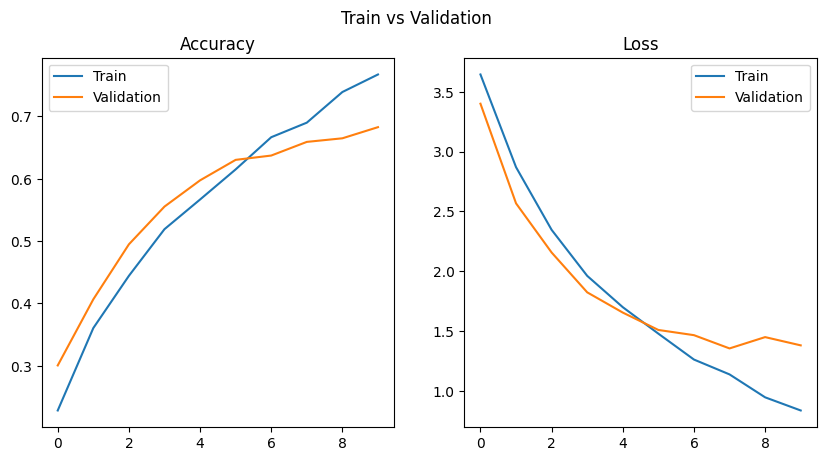

In [9]:
model= nn.DataParallel(model)
model.to(device)
summary(model, (3, 224, 224))

# Loss function
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epoch_number = 0

EPOCHS = 10
path_save_cp = './cp/'
best_vloss = 1_000_000.
training_logs = {"train_loss": [],  "train_acc": [], "validate_loss": [], "validate_acc": []}

t_0_accelerated = time.time()
for epoch in range(EPOCHS):
    train_loss, train_correct = 0, 0
    # Make sure gradient tracking is on, and do a pass over the data
    model.train(True)
    # Here, we use enumerate(training_loader) instead of
    # iter(training_loader) so that we can track the batch
    # index and do some intra-epoch reporting
    for i, data in enumerate(training_loader):
        # Every data instance is an input + label pair
        inputs, labels = data[0].to(device), data[1].to(device)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        train_loss += loss.item()
        train_correct += (outputs.argmax(1) == labels).float().sum().item()

    training_logs["train_loss"].append(train_loss / len(training_loader))
    training_logs["train_acc"].append(train_correct / len(training_loader.dataset))

    running_vloss = 0.0
    # Set the model to evaluation mode, disabling dropout and using population
    # statistics for batch normalization.
    model.eval()
    # Disable gradient computation and reduce memory consumption.
    valid_loss, valid_correct = 0, 0
    with torch.no_grad():
        for i, vdata in enumerate(validation_loader):
            vinputs, vlabels = vdata[0].to(device), vdata[1].to(device)
            voutputs = model(vinputs)
            vloss = loss_fn(voutputs, vlabels)
            valid_loss += loss_fn(voutputs, vlabels).item()
            valid_correct += (voutputs.argmax(1) == vlabels).float().sum().item()
        # save validation logs
        training_logs["validate_loss"].append(valid_loss / len(validation_loader))
        training_logs["validate_acc"].append(valid_correct / len(validation_loader.dataset))

    if epoch % 1 == 0:
        print(f"Epochs {epoch+1}".ljust(10),
            f"train loss {training_logs['train_loss'][-1]:.5f}",
            f"train acc {training_logs['train_acc'][-1]:.5f}",

            f"validate loss {training_logs['validate_loss'][-1]:.5f}",
            f"validate acc {training_logs['validate_acc'][-1]:.5f}",
            )
        print("-"*80)

    # Track best performance, and save the model's state
    if valid_loss < best_vloss:
        best_vloss = valid_loss
        # model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        if not os.path.exists(path_save_cp): os.mkdir(path_save_cp)
        torch.save(model.state_dict(), path_save_cp+'best_pretrainedmodel.pth')

    epoch_number += 1

t_end_accelerated = time.time()-t_0_accelerated
print(f"Time consumption for accelerated CUDA training (device:{device}): {t_end_accelerated} sec")
plot_graph(training_logs)